In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

import pickle

import ingest

from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, hstack
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import normalize


from joblib import parallel_backend

import xgboost as xgb

import math

import itertools
from tqdm import tqdm

from scipy import sparse




In [3]:
## input is a list of features from the nested dictionary that Taylor's code will spit out. The keys in this dictionary are associated with sparse matrices ##
## If the length of the input is greater than one, the function will do an hstack with those feats and their respective sparse matrices. If not the code    ##
## will simply take the input and run it through the SVD model to return a tuple with the matrix representation of the desired feature set along with the   ##
## Summation of the explained variation ratio array, along with a graph to show how the components are interacting to make-up total explainability. If the  ##
## If the hstack needs to be performed, then it will happen before the SVD model runs and render the above just the same.                                   ##



def PCA_encoder(f_dict,input,x):
    masterfeatdict = f_dict
    if len(input) == 4:
        a = masterfeatdict[input[0]]
        b = masterfeatdict[input[1]]
        c = masterfeatdict[input[2]]
        d = masterfeatdict[input[3]]
        stack = hstack([a,b,c,d])
    elif len(input) == 3:
        a = masterfeatdict[input[0]]
        b = masterfeatdict[input[1]]
        c = masterfeatdict[input[2]]
        stack = hstack([a,b,c])
    elif len(input) == 2:
        a = masterfeatdict[input[0]]
        b = masterfeatdict[input[1]]
        stack = hstack([a,b])
    else:
        stack = masterfeatdict[input[0]]


    encodedfeats = TruncatedSVD(n_components=x)

    encodedfeats_fit = encodedfeats.fit_transform(stack)

    exp_var_pca  = encodedfeats.explained_variance_ratio_

    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#   
    
# Create the visualization plot
#
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    return encodedfeats_fit,exp_var_pca.sum()

In [4]:
outpatient = ingest.get_cache_data("Outpatient", "Outpatient.pkl")
outpatient.dropna(subset=['CLM_PMT_AMT'], inplace=True)
outpatient = outpatient[['CLM_PMT_AMT']]

INFO:root:Reading local cache file Outpatient.pkl


BIRTH_DATE
(790790, 1)
SEX
(790790, 1)
State
(790790, 52)
County
(790790, 306)
clm_dates
(790790, 1)
provider
(790790, 4317)
provider_count
(790790, 1)
DGNS_CD
(790790, 11702)
DGNS_CD_count
(790790, 1)
PRDCR_CD
(790790, 288)
PRDCR_CD_count
(790790, 1)
HCPCS_CD
(790790, 5619)
HCPCS_CD_count
(790790, 1)


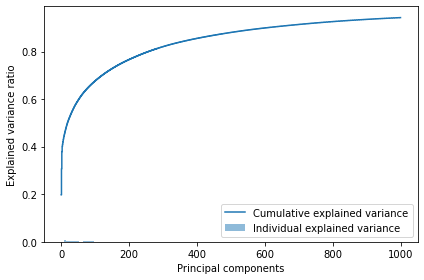

0.9425266015333092


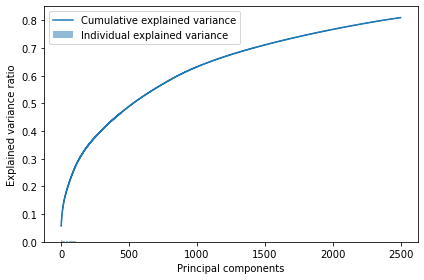

0.8099198355832538


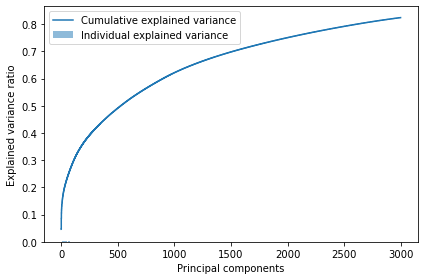

0.8245701866931845


In [5]:
with open('feature_vectors_dictionary-truncated.txt', 'rb') as handle:
    feature_dictionary = pickle.load(handle)

for met_set in feature_dictionary.keys():
    print(met_set)
    feature_dictionary[met_set] = normalize(sparse.csr_matrix(feature_dictionary[met_set]))
    print(np.shape(feature_dictionary[met_set]))


feature_dictionary['PCA-HCPCS_CD'], wow1 = PCA_encoder(feature_dictionary, ['HCPCS_CD'],1000)
print(wow1)

feature_dictionary['PCA-DGNS_CD'], wow2 = PCA_encoder(feature_dictionary, ['DGNS_CD'],2500)
print(wow2)

feature_dictionary['PCA-HCPCS-DGNS_CD'], wow3 = PCA_encoder(feature_dictionary, ['HCPCS_CD', 'DGNS_CD'],3000)
print(wow3)

In [6]:
def run_model(X, y, model, grid, feature_names):

       ### Runs the model and returns MSE and R2 values and corresponding data as a dataframe

       ### Takes in four arugments
       ### X is the features to that model will be trained on as a sparse matrix
       ### y is the scalar that is to be predicted as a list
       ### model is the regression model as a model object
       ### grid is a dictionary of model hyperparameters

       ### returns a dataframe of results from the grid search

       scoring = {'mean_squared_error': make_scorer(mean_squared_error), 'r2_score': make_scorer(r2_score)}
       with parallel_backend('threading', n_jobs=2):
              grid_model = GridSearchCV(model, grid, scoring=scoring, refit=False, return_train_score=True, error_score="raise").fit(X.todense(), y)
       
       print(grid_model.cv_results_)

       df=pd.DataFrame.from_dict(grid_model.cv_results_)
       
       return df

In [7]:
def iterate_feature_sets(model, feature_dict, grid, feature_sets):

    ### Creates and runs the specified model with each comboniation of features sets from 1 to k length features and stores the results of the models into a dictionary

    ### Takes in four arguments
    ### model is the regression model as a model object
    ### feature_dict is the dictionary of feature sets
    ### grid is a dictionary of model hyperparameters
    ### feature_sets dicates how what feature sets will be returned, a list of list of strings corresponding to the keys in the dictionary
    ### (continued) all would return all combinations for 1 through k, where  k is the number of keys in feature_dict

    ### returns a dictionary of results

    results = {}

    for feature_list in feature_sets:
        if feature_list == 'all':

            for n_met in tqdm(range(len(feature_dict))):
                for met_set in list(itertools.combinations(feature_dict.keys(), n_met+1)):
                    for n_met_set in range(len(met_set)):
                        if n_met_set == 0:
                            X = feature_dict[met_set[n_met_set]]
                        else:
                            X  = sparse.hstack((X,feature_dict[met_set[n_met_set]]), format='csr')
                    answer = run_model(X, outpatient['CLM_PMT_AMT'].values.tolist(), model, grid, met_set)
                    results[met_set] = answer

        else:
            X = None
            Name = ()
            for i in feature_list:
                if X == None:
                    X = feature_dict[i]
                    Name += (i,)
                else:
                    X = sparse.hstack((X, feature_dict[i]), format='csr')
                    Name += (i,)
            answer = run_model(X, outpatient['CLM_PMT_AMT'].values.tolist(), model, grid, feature_list)
            results[Name] = answer
        
    return results

In [8]:
def write_results(results_dict, filename):

    ### Takes in two arguements
    ### results_dict is the dictionary of feature sets
    ### file name is the wanted file name as a string

    ### Returns None, but writes a file to the current directory


    df = pd.DataFrame()

    for r_key in results_dict.keys():
        temp_df = results_dict[r_key]
        temp_df['features'] = str(r_key)
        df = pd.concat((df, temp_df), ignore_index=True)

    df.to_csv(filename)

    return None

# Final Histogram Gradient Boosted PCA Supervised Run
### See how the model performs on the dataset with PCA

In [9]:
grid_dict = {'learning_rate': [0.25],
    'max_iter': [200],
    #wanted to go a little higher on leaf nodes since there seemed to be more to gain
    'max_leaf_nodes': [10],
    'max_depth': [18]
    #results were inconclusive for minimum samples, going to leave as default
    }


GBRModel = HistGradientBoostingRegressor(random_state=42)
write_results(iterate_feature_sets(GBRModel, feature_dictionary, grid_dict, [
    # picked because of speed and results
    ['clm_dates', 'PCA-DGNS_CD', 'PCA-HCPCS_CD', 'BIRTH_DATE', 'SEX', 'State', 'County'],
    ['clm_dates', 'PCA-HCPCS-DGNS_CD', 'BIRTH_DATE', 'SEX', 'State', 'County']]), 'PCA_Final_GBRModel.csv')


{'mean_fit_time': array([810.20943007]), 'std_fit_time': array([231.51930883]), 'mean_score_time': array([9.08365698]), 'std_score_time': array([8.94627708]), 'param_learning_rate': masked_array(data=[0.25],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[18],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_iter': masked_array(data=[200],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_leaf_nodes': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.25, 'max_depth': 18, 'max_iter': 200, 'max_leaf_nodes': 10}], 'split0_test_mean_squared_error': array([218156.09367574]), 'split1_test_mean_squared_error': array([217510.15012205]), 'split2_test_mean_squared_error': array([217644.2480655]), 'split3_test_mean_squared_error': array([223195.82319331]), 'split4_test_mean_

# Final Stochastic Gradient Descent PCA Supervised Run
### See how the model performs on the dataset with PCA

In [10]:
grid_dict = {'loss': ['squared_epsilon_insensitive'],
    'penalty': ['l1'],
    'alpha': [.0001],
    'max_iter': [1000]}

SGDModel = SGDRegressor(random_state=42)
write_results(iterate_feature_sets(SGDModel, feature_dictionary, grid_dict, [
    ['clm_dates', 'PCA-DGNS_CD', 'PCA-HCPCS_CD', 'BIRTH_DATE', 'SEX', 'State', 'County'],
    ['clm_dates', 'PCA-HCPCS-DGNS_CD', 'BIRTH_DATE', 'SEX', 'State', 'County']]), 'PCA_Final_SGDModel.csv')

{'mean_fit_time': array([2753.62727251]), 'std_fit_time': array([2342.89507068]), 'mean_score_time': array([30.0611599]), 'std_score_time': array([7.32015651]), 'param_alpha': masked_array(data=[0.0001],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_loss': masked_array(data=['squared_epsilon_insensitive'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_iter': masked_array(data=[1000],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_penalty': masked_array(data=['l1'],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.0001, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000, 'penalty': 'l1'}], 'split0_test_mean_squared_error': array([232241.33463155]), 'split1_test_mean_squared_error': array([233127.96589307]), 'split2_test_mean_squared_error': array([233732.24342608]), 'split3_test_mean_squared_error': array([239466.690

# Final Elastic Net NonPCA Supervised Run
### See how the model performs on the dataset without PCA

In [ ]:
grid_dict = {'alpha': [.0001],
    'l1_ratio': [.9]}

ENModel = ElasticNet(random_state=42)
write_results(iterate_feature_sets(ENModel, feature_dictionary, grid_dict, [
    ['clm_dates', 'PCA-DGNS_CD', 'PCA-HCPCS_CD', 'BIRTH_DATE', 'SEX', 'State', 'County'],
    ['clm_dates', 'PCA-HCPCS-DGNS_CD', 'BIRTH_DATE', 'SEX', 'State', 'County']]), 'PCA_Final_ENModel.csv')

{'mean_fit_time': array([860.89285092]), 'std_fit_time': array([194.92109062]), 'mean_score_time': array([2.9623363]), 'std_score_time': array([0.94149851]), 'param_alpha': masked_array(data=[0.0001],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_l1_ratio': masked_array(data=[0.9],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.0001, 'l1_ratio': 0.9}], 'split0_test_mean_squared_error': array([234622.4237691]), 'split1_test_mean_squared_error': array([236443.48547151]), 'split2_test_mean_squared_error': array([237652.22084051]), 'split3_test_mean_squared_error': array([243252.95701962]), 'split4_test_mean_squared_error': array([242310.02897025]), 'mean_test_mean_squared_error': array([238856.2232142]), 'std_test_mean_squared_error': array([3360.2388376]), 'rank_test_mean_squared_error': array([1]), 'split0_train_mean_squared_error': array([238647.21062529]), 'split1_train_mean_squared_error': arra

# Final CXGBoost NonPCA Supervised Run
### See how the model performs on the dataset without PCA

In [ ]:
grid_dict = {'max_depth': [10],
    'number_of_estimators': [9],
    'tree_method': ['hist']}

XGBModel = xgb.XGBRFRegressor(random_state=42)
write_results(iterate_feature_sets(XGBModel, feature_dictionary, grid_dict, [
    ['clm_dates', 'PCA-DGNS_CD', 'PCA-HCPCS_CD', 'BIRTH_DATE', 'SEX', 'State', 'County'],
    ['clm_dates', 'PCA-HCPCS-DGNS_CD', 'BIRTH_DATE', 'SEX', 'State', 'County']]), 'PCA_Final_XGBModel.csv')

{'mean_fit_time': array([201.49722433]), 'std_fit_time': array([31.13037309]), 'mean_score_time': array([1.62110672]), 'std_score_time': array([0.45685497]), 'param_max_depth': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_number_of_estimators': masked_array(data=[9],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_tree_method': masked_array(data=['hist'],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 10, 'number_of_estimators': 9, 'tree_method': 'hist'}], 'split0_test_mean_squared_error': array([227138.4239546]), 'split1_test_mean_squared_error': array([226438.33402914]), 'split2_test_mean_squared_error': array([227835.52620283]), 'split3_test_mean_squared_error': array([232350.22450248]), 'split4_test_mean_squared_error': array([231112.14943849]), 'mean_test_mean_squared_error': array([228974.93162551]), 'std_test_mean_squared_error